# Dataset

### Download the dataset using Kaggle API

In [2]:
# Dataset link  ----->>  https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset

In [3]:
!pip install -q kaggle

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d vikramtiwari/pix2pix-dataset

 99% 2.37G/2.40G [00:23<00:00, 102MB/s] 
100% 2.40G/2.40G [00:23<00:00, 111MB/s]


In [7]:
!unzip -q /content/pix2pix-dataset.zip

### Function to split every image to make the input and the output for the model

In [207]:
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image

In [208]:
img_test_path = '/content/cityscapes/cityscapes/val/1.jpg'

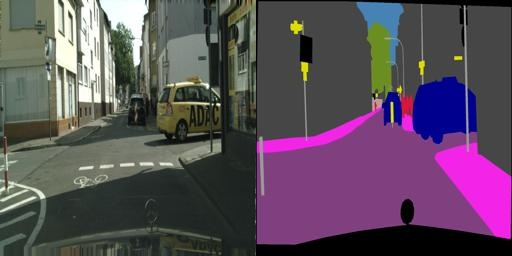

In [209]:
image = Image.open(img_test_path)
image

In [210]:
def load_split(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3) # Array of size (256, 512, 3)
    w = tf.shape(image)[1]//2  # 512//2 = 256
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    return tf.cast(input_image, tf.float32), tf.cast(real_image, tf.float32)

In [211]:
def imshow(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [212]:
inp, out = load_split(img_test_path)
inp, out = inp/255, out/255  # Rescale the images from [0, 255] to [0, 1]
print(inp.shape)
inp.shape==out.shape

(256, 256, 3)


True

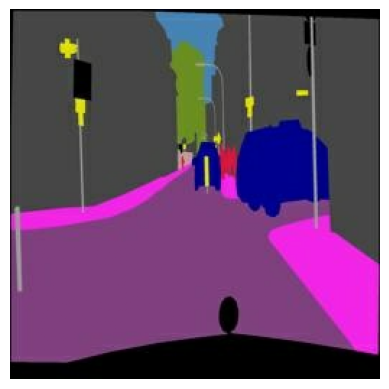

In [213]:
imshow(inp)

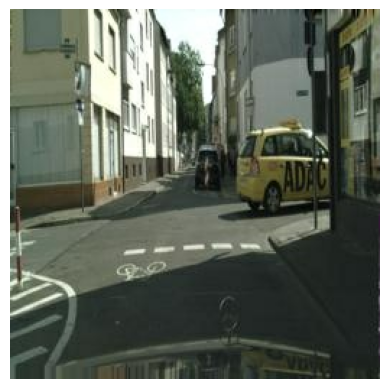

In [214]:
imshow(out)

### Functions for Image Preprocessing

In [215]:
def normalize_and_resize(input_image, real_image, norm=True, imsize=(256, 256), res=True):
    if norm: # Rescale the images from [0, 255] to [-1, 1]
        input_image = (input_image / 127.5) - 1
        real_image = (real_image / 127.5) - 1
    if res:
        input_image = tf.image.resize(input_image, imsize, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        real_image = tf.image.resize(real_image, imsize, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [216]:
def flip(input_image, real_image):
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

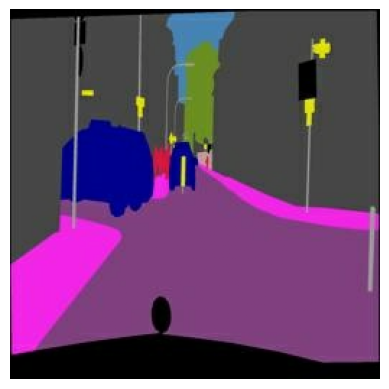

In [217]:
fliped_inp, fliped_out = flip(inp, out)
imshow(fliped_inp)

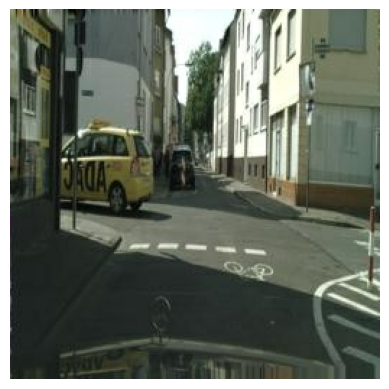

In [218]:
imshow(fliped_out)

## Load the training and testing data

In [219]:
def load_train(image_path):
    input_image, real_image = load_split(image_path)
    input_image, real_image = normalize_and_resize(input_image, real_image, norm=False)
    input_image, real_image = flip(input_image, real_image)
    input_image, real_image = normalize_and_resize(input_image, real_image, res=False)
    return input_image, real_image

In [220]:
def load_val(image_path):
    input_image, real_image = load_split(image_path)
    input_image, real_image = normalize_and_resize(input_image, real_image, norm=False)
    input_image, real_image = normalize_and_resize(input_image, real_image, res=False)
    return input_image, real_image

In [221]:
BATCH_SIZE = 1

train_dataset = tf.data.Dataset.list_files('/content/cityscapes/cityscapes/train/*.jpg')
print(len(train_dataset))
train_dataset = train_dataset.map(load_train)
train_dataset = train_dataset.shuffle(16).batch(BATCH_SIZE)
len(train_dataset)

2975


2975

In [222]:
val_dataset = tf.data.Dataset.list_files('/content/cityscapes/cityscapes/val/*.jpg')
print(len(val_dataset))
val_dataset = val_dataset.map(load_val)
val_dataset = val_dataset.batch(BATCH_SIZE)
len(val_dataset)

500


500

# Models Building

### Downsample Block

In [223]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Dropout

In [252]:
def downsample(filters, size, batch_norm = False):
    init = tf.random_normal_initializer(0., 0.02)
    downsample_layer = Sequential([
        Conv2D(filters, size, 2, "same", kernel_initializer = init, use_bias = False)
    ])
    if batch_norm: downsample_layer.add(BatchNormalization())
    downsample_layer.add(LeakyReLU())
    return downsample_layer

In [225]:
tf.expand_dims(inp, 0).shape

TensorShape([1, 256, 256, 3])

In [226]:
ds_model_test = downsample(3, 4)
downsample_out = ds_model_test(tf.expand_dims(inp, 0))
downsample_out.shape

TensorShape([1, 128, 128, 3])

### Upsample Block

In [227]:
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    upsample_layer = Sequential([
        Conv2DTranspose(filters, size, 2, "same", kernel_initializer = init, use_bias = False),
        BatchNormalization()
    ])

    if dropout: upsample_layer.add(Dropout(0.5))
    upsample_layer.add(ReLU())

    return upsample_layer

In [228]:
us_model_test = upsample(3, 4)
upsample_out = us_model_test(downsample_out)
upsample_out.shape

TensorShape([1, 256, 256, 3])

### Generator

In [229]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [253]:
inp_img_size = (256, 256, 3)

input_layer = Input(shape = inp_img_size)
down_stack = [
    downsample(64, 4),
    downsample(128, 4),
    downsample(256, 4, batch_norm=True),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4, batch_norm=True),
    downsample(512, 4),
    downsample(512, 4)
]


up_stack = [
    upsample(512, 4, dropout=True),
    upsample(512, 4),
    upsample(512, 4),
    upsample(512, 4, dropout=True),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4),
]
init = tf.random_normal_initializer(0., 0.02)
last = Conv2DTranspose(3, 4, 2, "same", kernel_initializer = init, activation ="tanh")
x = input_layer
downs = []
for down in down_stack:
    x = down(x)
    downs.append(x)
downs = downs[:-1][::-1]

for up, skip in zip(up_stack, downs):
    x = up(x)
    x = Concatenate()([x, skip])

out = last(x)
generator = Model(inputs = input_layer, outputs = out)

In [254]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131072    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_1[0][0]']        
                                                                                              

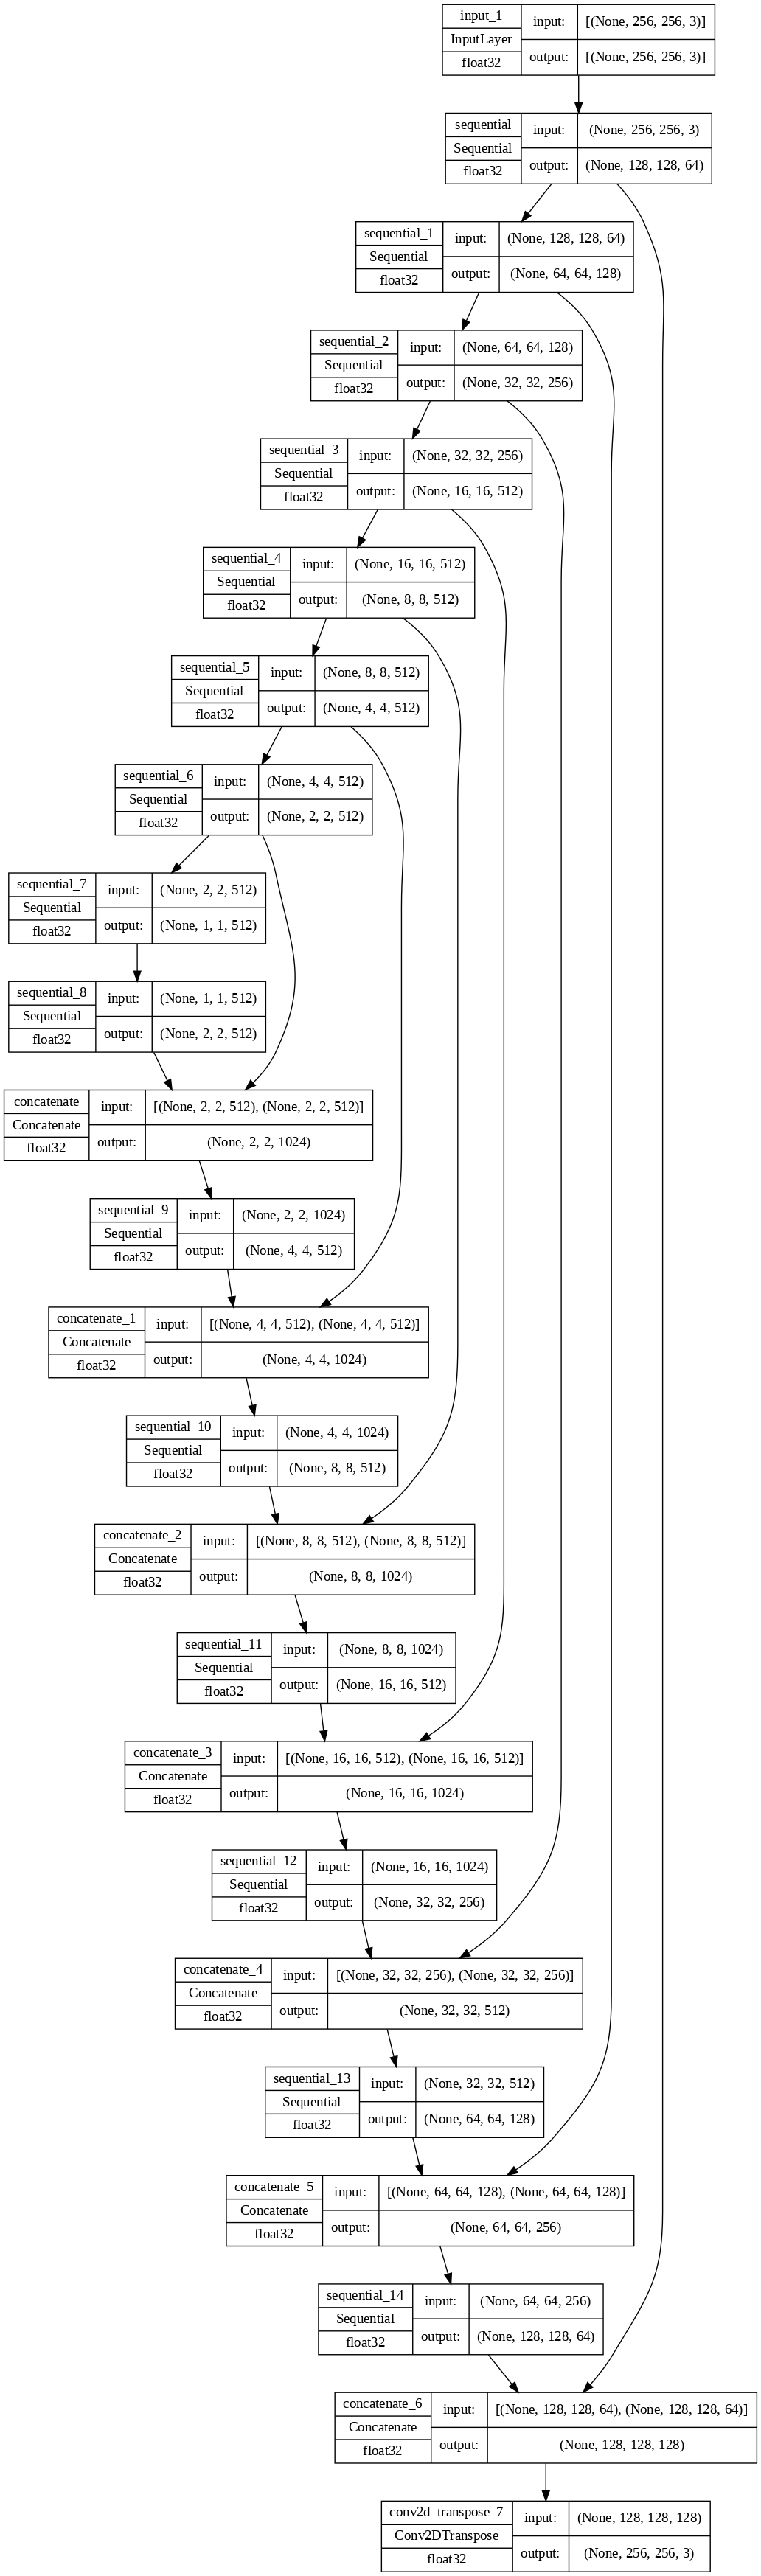

In [255]:
plot_model(generator, show_shapes=True, show_dtype=True, dpi=100)

In [256]:
BCELoss = BinaryCrossentropy(from_logits=True)

In [257]:
def gen_loss(disc_out, gen_out, target, lambda_val = 100):
    gan_loss = BCELoss(tf.ones_like(disc_out), disc_out)
    l1_loss = tf.reduce_mean(tf.abs(target-gen_out))
    total_loss = gan_loss + lambda_val*l1_loss
    return total_loss

In [258]:
gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

### Discriminator

In [237]:
from tensorflow.keras.layers import ZeroPadding2D

In [238]:
inp_img_size

(256, 256, 3)

In [259]:
init = tf.random_normal_initializer(0., 0.02)

inp = Input(shape = inp_img_size, name = "input_image")
tar = Input(shape = inp_img_size, name = "target_image")

x = Concatenate()([inp, tar])
down = downsample(64, 4)(x)
down = downsample(128, 4, True)(down)
down = downsample(256, 4)(down)

pad = ZeroPadding2D()(down)
conv = Conv2D(256, 4, 1, kernel_initializer = init, use_bias = False)(pad)
leaky_relu = LeakyReLU()(conv)

pad = ZeroPadding2D()(leaky_relu)
out = Conv2D(1, 4, 1, kernel_initializer=init)(pad)

discriminator = Model(inputs = [inp, tar], outputs = out)

In [260]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 256, 256, 6)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 sequential_15 (Sequential)  (None, 128, 128, 64)         6144      ['concatenate_7[0][0]'] 

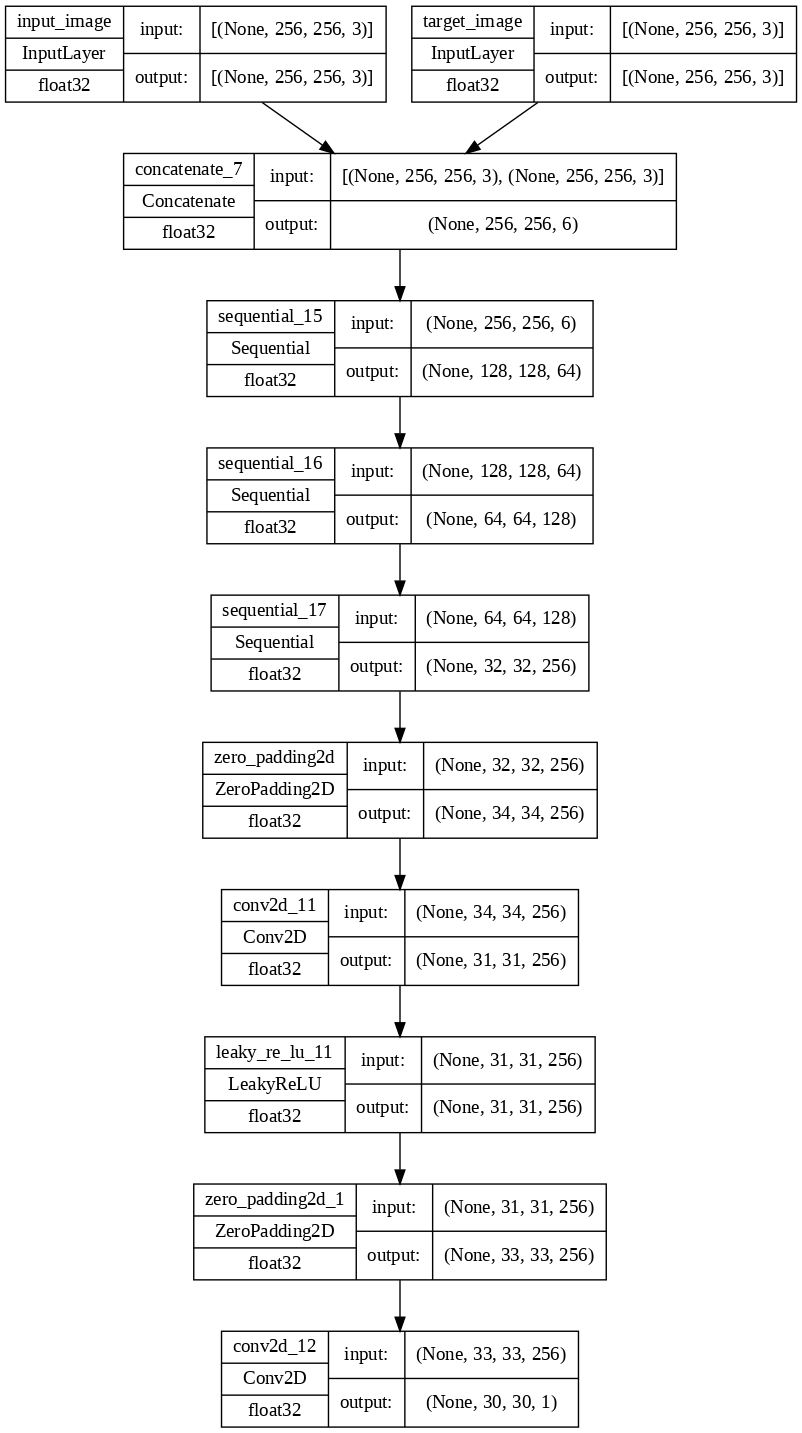

In [261]:
plot_model(discriminator, show_shapes=True, show_dtype=True, dpi=100)

In [262]:
def disc_loss(real_out, fake_out):
    real_loss = BCELoss(tf.ones_like(real_out), real_out)
    fake_loss = BCELoss(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

In [263]:
disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Training

## Prepare for training

In [168]:
import os

In [264]:
def n_epoch_results_save(generator, inp_img, tar_img, epoch):
    prediction = generator(inp_img) # inp_shape = out_shape = (1, 256, 256, 3)

    images = [inp_img[0], tar_img[0], prediction[0]]
    titles = ['Input_Image', 'Target_Image', 'Generated_Image']
    plt.figure(figsize=(15, 15))

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(images[i]*0.5 + 0.5) # Rescale from [-1, 1] to [0, 1]
        plt.axis('off')

    if not os.path.exists('results'): os.mkdir('results')
    plt.savefig(f"results/epoch_{epoch}.jpg")
    # plt.close()

## Training

In [265]:
from tqdm import tqdm
import keras

keras.backend.clear_session()

In [266]:
@tf.function
def train_step(input_image, target_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training = True)

        disc_real_out = discriminator([input_image, target_image], training = True)
        disc_fake_out = discriminator([input_image, gen_output], training = True)

        genLoss = gen_loss(disc_fake_out, gen_output, target_image)
        discLoss = disc_loss(disc_real_out, disc_fake_out)

        generator_gradients = gen_tape.gradient(genLoss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

        discriminator_gradients = disc_tape.gradient(discLoss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        return genLoss, discLoss


Epoch 1


100%|██████████| 2975/2975 [04:12<00:00, 11.76it/s]


Generator loss -> 28.54 ------------ Discriminator loss -> 0.31

Epoch 2


100%|██████████| 2975/2975 [04:21<00:00, 11.36it/s]


Generator loss -> 19.06 ------------ Discriminator loss -> 0.53

Epoch 3


100%|██████████| 2975/2975 [04:06<00:00, 12.06it/s]


Generator loss -> 30.63 ------------ Discriminator loss -> 0.27

Epoch 4


100%|██████████| 2975/2975 [04:06<00:00, 12.07it/s]


Generator loss -> 22.05 ------------ Discriminator loss -> 0.65

Epoch 5


100%|██████████| 2975/2975 [04:06<00:00, 12.07it/s]


Generator loss -> 16.44 ------------ Discriminator loss -> 0.53

Epoch 6


100%|██████████| 2975/2975 [04:07<00:00, 12.03it/s]


Generator loss -> 18.20 ------------ Discriminator loss -> 0.69

Epoch 7


100%|██████████| 2975/2975 [04:07<00:00, 12.03it/s]


Generator loss -> 18.00 ------------ Discriminator loss -> 1.57

Epoch 8


100%|██████████| 2975/2975 [04:06<00:00, 12.09it/s]


Generator loss -> 18.13 ------------ Discriminator loss -> 0.45

Epoch 9


100%|██████████| 2975/2975 [04:05<00:00, 12.12it/s]


Generator loss -> 22.41 ------------ Discriminator loss -> 0.80


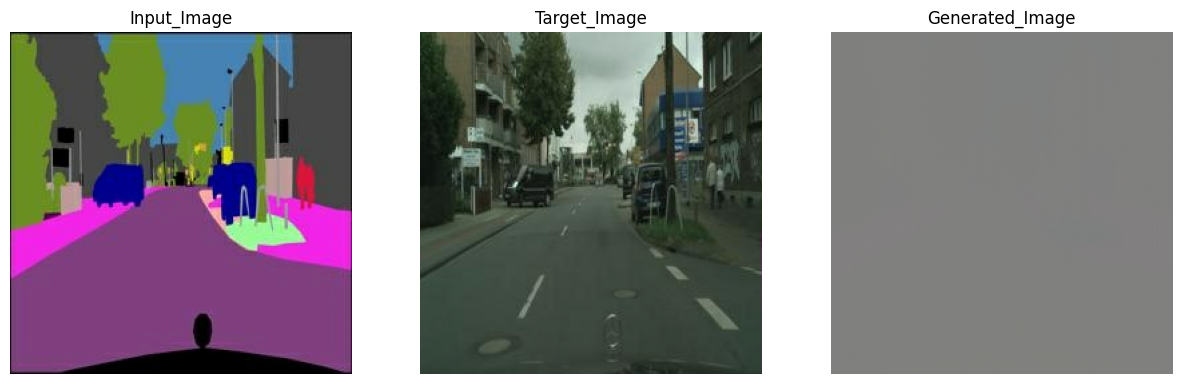

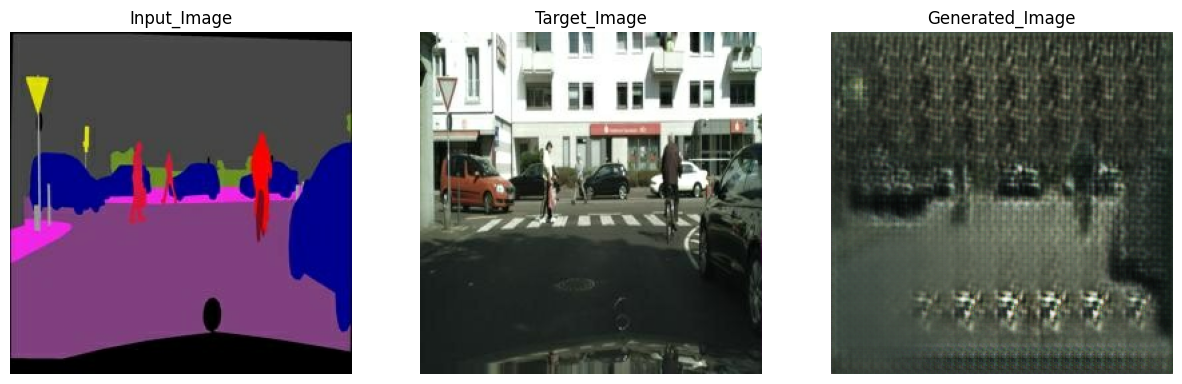

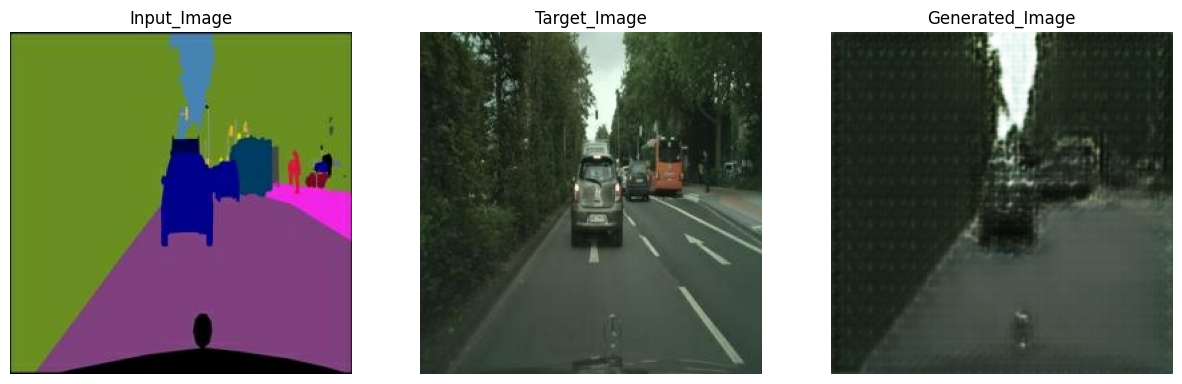

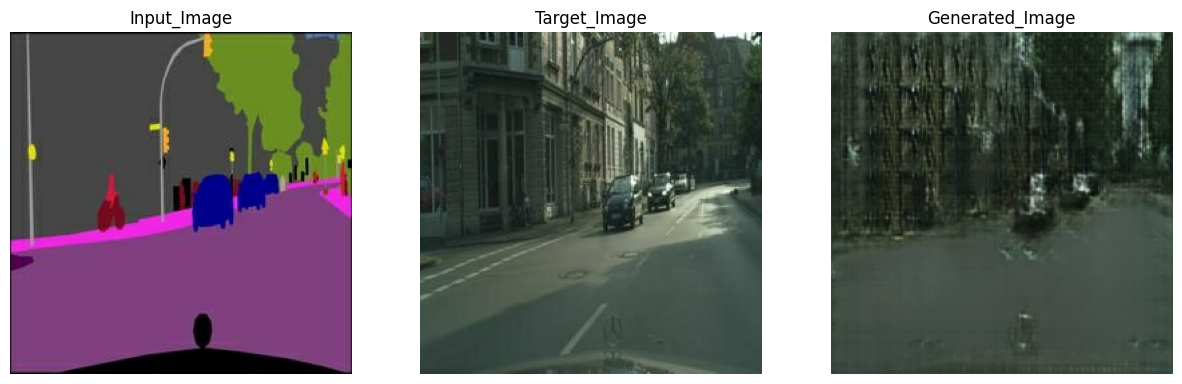

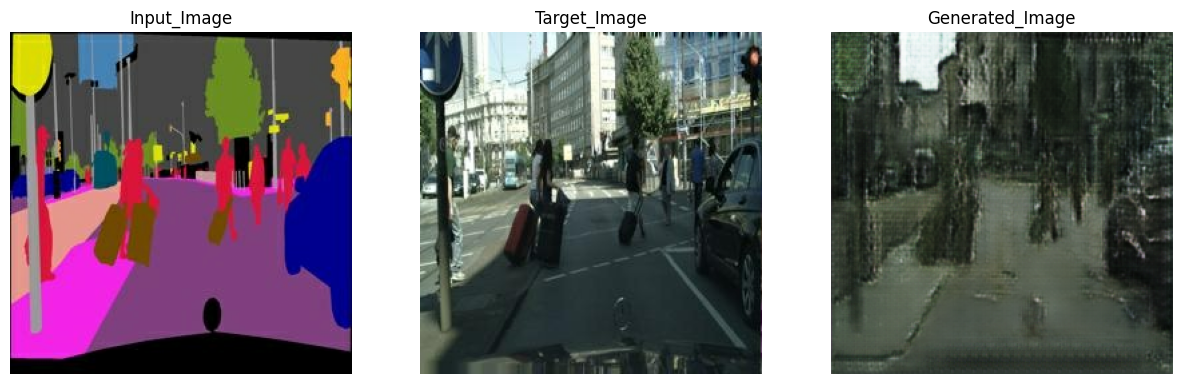

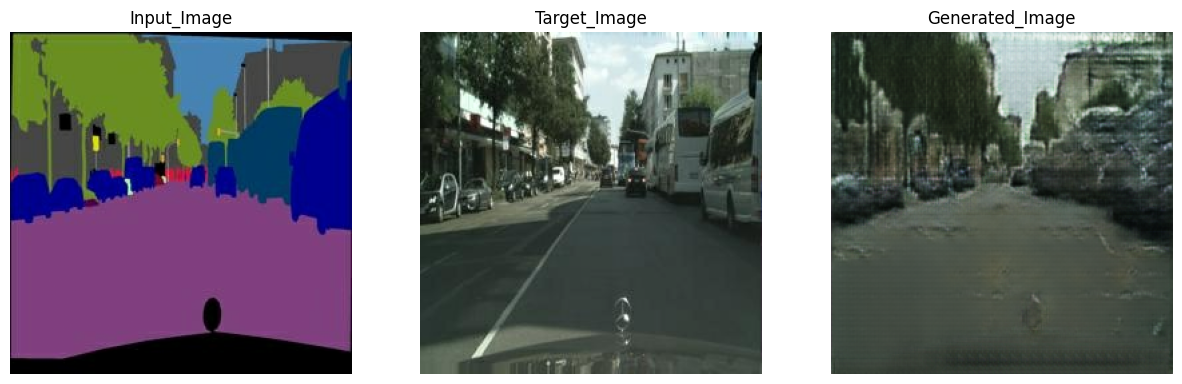

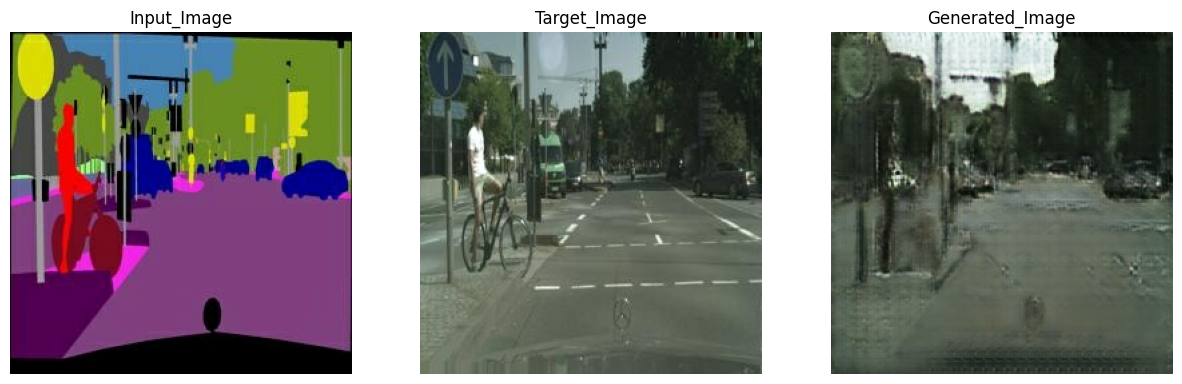

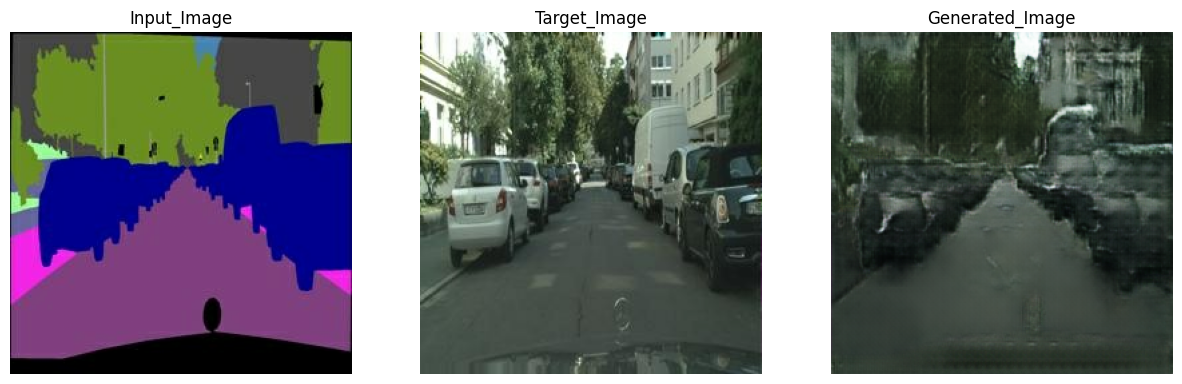

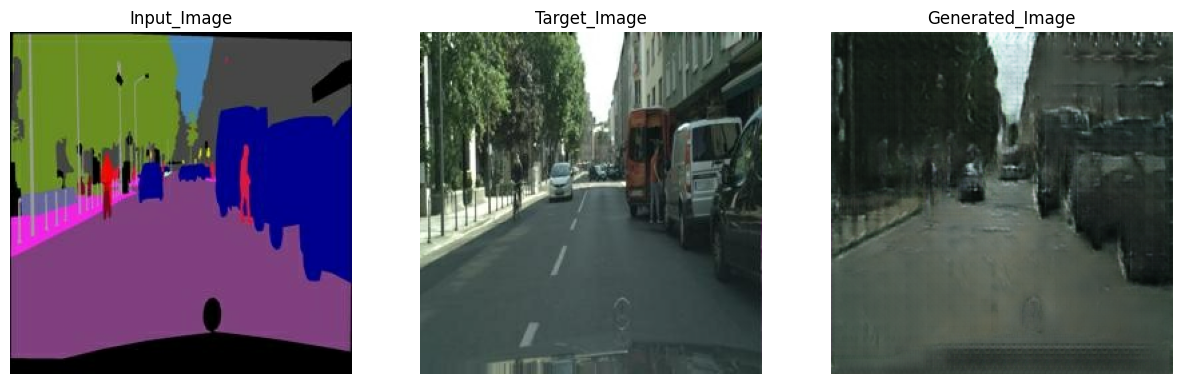

In [268]:
epochs = 9
gen_losses, disc_losses = [], []

for epoch in range(epochs):
    for input_img, target_img in val_dataset.take(1):
        n_epoch_results_save(generator, input_img, target_img, epoch+1)
    print(f"\nEpoch {epoch+1}")
    for input_img, target_img in tqdm(train_dataset):
        gen_loss_val, disc_loss_val = train_step(input_img, target_img)
        gen_losses.append(gen_loss_val)
        disc_losses.append(disc_loss_val)
    print("Generator loss -> {:.2f} ------------ Discriminator loss -> {:.2f}".format(gen_loss_val, disc_loss_val))